## Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import f_oneway
pd.pandas.set_option('display.max_columns', None) 
sns.set_theme(color_codes = True)

import os
import sys
import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# ELO
from ELO import ELO

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, mean_squared_error

# pytorch
import torch
print(torch.cuda.is_available())

# Wandb
import wandb
wandb.login(key = '95d4fb2d02fe3866b9b32239df088d24cccd2efe')

# Catboost
from catboost import Pool, CatBoostClassifier, CatBoostRegressor

# XGBoost
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance as xgb_plot_importance

# LightGBM
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import plot_importance as lgbm_plot_importance

# Optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback, XGBoostPruningCallback

# 정답률을 빠르게 구하기 위해 함수 정의
def percentile(s) :
    return np.sum(s) / len(s)

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
seed_everything(SEED)

True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jw0112 (teemo-dkt). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/.netrc


## Data Import

In [4]:
%time
dtype = {'userID' : 'int16',
         'answerCode' : 'int8',
         'KnowledgeTag' : 'int16'}   

DATA_PATH = './data/'

train = pd.read_csv(DATA_PATH + 'train_data.csv', dtype = dtype, parse_dates = ['Timestamp'])
train = train.sort_values(by = ['userID', 'Timestamp']).reset_index(drop = True)

test = pd.read_csv(DATA_PATH + 'test_data.csv', dtype = dtype, parse_dates = ['Timestamp'])
test = test.sort_values(by = ['userID', 'Timestamp']).reset_index(drop = True)

print(train.shape, test.shape)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs
(2266586, 6) (260114, 6)


## Preprocessing

In [25]:
def Feature_Engineering(df) :
    '''
    전처리 및 변수 생성을 위한 함수
    '''
    df.sort_values(by = ['userID', 'Timestamp'], inplace = True)

    # 시험지 대분류, 시험지 고유 번호, 시험 문항 번호
    df['testID'] = df['assessmentItemID'].apply(lambda x : x[1:7])
    df['testCode'] = df['assessmentItemID'].apply(lambda x : x[2:3]).astype('int8')
    df['testNum'] = df['assessmentItemID'].apply(lambda x : x[4:7]).astype('int16')
    df['problemID'] = df['assessmentItemID'].apply(lambda x : x[7:]).astype('int16')
    df['problemID_Norm'] = (df['problemID'] - min(df['problemID'])) / (max(df['problemID']) - min(df['problemID']))
    
    # testCode 별 중복되는 KnowledgeTag 전처리
    df.loc[df['KnowledgeTag'] == 7863, 'testCode'] = 7
    
    # 문제를 푼 날짜 정보 중 년, 월, 일, 시간, 요일, 평일 여부 정보
    df['year'] = df['Timestamp'].dt.year.astype('int16')
    df['month'] = df['Timestamp'].dt.month.astype('int8')
    df['day'] = df['Timestamp'].dt.day.astype('int8')
    df['hour'] = df['Timestamp'].dt.hour.astype('int8')
    df['dow'] = df['Timestamp'].dt.dayofweek.astype('int8')
    df['date'] = df['Timestamp'].dt.date
    df['weekday'] = np.where(df['dow'] >= 5, 0, 1).astype('int8')
    
    # 문제를 푸는데 걸린 시간
    df['ElapsedTime'] = df.groupby(['userID', 'testID'], as_index = False)['Timestamp'].diff().shift(-1)
    df['ElapsedTime'] = df['ElapsedTime'].apply(lambda x : x.total_seconds())
    df.loc[df['ElapsedTime'] > 1200, 'ElapsedTime'] = np.nan # 20분(1200초) 초과 -> 결측
    df['ElapsedTime'] = df.groupby('problemID')['ElapsedTime'].transform(lambda x: x.fillna(x.mean())) # 문제 번호 별 평균 풀이 시간으로 결측치 대체
    
    # 유저가 문제를 푼 시간 이동평균
    df['ElapsedTime_rolling2'] = df.groupby('userID')['ElapsedTime'].rolling(2).mean().values
    df['ElapsedTime_rolling2'] = df['ElapsedTime_rolling2'].fillna(0)
    df['ElapsedTime_rolling3'] = df.groupby('userID')['ElapsedTime'].rolling(3).mean().values
    df['ElapsedTime_rolling3'] = df['ElapsedTime_rolling3'].fillna(0)
    df['ElapsedTime_rolling4'] = df.groupby('userID')['ElapsedTime'].rolling(4).mean().values
    df['ElapsedTime_rolling4'] = df['ElapsedTime_rolling4'].fillna(0)
    df['ElapsedTime_rolling5'] = df.groupby('userID')['ElapsedTime'].rolling(5).mean().values
    df['ElapsedTime_rolling5'] = df['ElapsedTime_rolling5'].fillna(0)
    
    # userID, assessmentItemID, testID, testCode, testNum, problemID, KnowledgeTag 별 평균 문제 풀이 시간
    df['user_ElaspedTime_avg'] = df['userID'].map(df.groupby('userID')['ElapsedTime'].mean().to_dict())
    df['item_ElaspedTime_avg'] = df['assessmentItemID'].map(df.groupby('assessmentItemID')['ElapsedTime'].mean().to_dict())
    df['testID_ElaspedTime_avg'] = df['testID'].map(df.groupby('testID')['ElapsedTime'].mean().to_dict())
    df['testCode_ElaspedTime_avg'] = df['testCode'].map(df.groupby('testCode')['ElapsedTime'].mean().to_dict())
    df['testNum_ElaspedTime_avg'] = df['testNum'].map(df.groupby('testNum')['ElapsedTime'].mean().to_dict())
    df['problem_ElaspedTime_avg'] = df['problemID'].map(df.groupby('problemID')['ElapsedTime'].mean().to_dict())
    df['tag_ElaspedTime_avg'] = df['KnowledgeTag'].map(df.groupby('KnowledgeTag')['ElapsedTime'].mean().to_dict())
    
    # 유저가 문제를 실제로 풀었는지 여부 (9초부터 평균 정답률 이상이므로, 9초 미만은 찍은 걸로 간주)
    df['Real_Solved'] = np.where(df['ElapsedTime'] >= 9, 1, 0).astype('int8')
    
    # 유저가 해당 문제를 이전에 몇 번 풀었는지
    df['user_past'] = df.groupby(['userID', 'assessmentItemID'])['answerCode'].shift(1).fillna(0).astype('int8')
    df['user_past_solved'] = df.groupby(['userID', 'assessmentItemID'])['user_past'].cumsum().astype('int8')
    
    # 유저가 정답을 맞힌 횟수 / 문제를 푼 횟수 / 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x : x.cumsum().shift(1)).fillna(0).astype('int16')
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount().astype('int16')
    df['user_acc'] = (df['user_correct_answer'] / df['user_total_answer']).fillna(0)

    # 유저가 assessmentItemID 별 정답을 맞힌 횟수 / 문제를 푼 횟수 / 정답률을 시간순으로 누적해서 계산
    df['user_itemID_correct_answer'] = df.groupby(['userID', 'assessmentItemID'])['answerCode'].transform(lambda x : x.cumsum().shift(1)).fillna(0).astype('int16')
    df['user_itemID_total_answer'] = df.groupby(['userID', 'assessmentItemID'])['answerCode'].cumcount().astype('int16')
    df['user_itemID_acc'] = (df['user_itemID_correct_answer'] / df['user_itemID_total_answer']).fillna(0)
    
    # 유저가 testID 별 정답을 맞힌 횟수 / 문제를 푼 횟수 / 정답률을 시간순으로 누적해서 계산
    df['user_testID_correct_answer'] = df.groupby(['userID', 'testID', 'date'])['answerCode'].transform(lambda x : x.cumsum().shift(1)).fillna(0).astype('int16')
    df['user_testID_total_answer'] = df.groupby(['userID', 'testID', 'date'])['answerCode'].cumcount().astype('int16')
    df['user_testID_acc'] = (df['user_testID_correct_answer'] / df['user_testID_total_answer']).fillna(0)

    # 유저가 testID 별 정답을 맞힌 횟수 / 문제를 푼 횟수 / 정답률을 시간순으로 누적해서 계산
    df['user_testCode_correct_answer'] = df.groupby(['userID', 'testCode'])['answerCode'].transform(lambda x : x.cumsum().shift(1)).fillna(0).astype('int16')
    df['user_testCode_total_answer'] = df.groupby(['userID', 'testCode'])['answerCode'].cumcount().astype('int16')
    df['user_testCode_acc'] = (df['user_testCode_correct_answer'] / df['user_testCode_total_answer']).fillna(0)

    # 유저가 testNum 별 정답을 맞힌 횟수 / 문제를 푼 횟수 / 정답률을 시간순으로 누적해서 계산
    df['user_testNum_correct_answer'] = df.groupby(['userID', 'testNum'])['answerCode'].transform(lambda x : x.cumsum().shift(1)).fillna(0).astype('int16')
    df['user_testNum_total_answer'] = df.groupby(['userID', 'testNum'])['answerCode'].cumcount().astype('int16')
    df['user_testNum_acc'] = (df['user_testNum_correct_answer'] / df['user_testNum_total_answer']).fillna(0)
    
    # 유저가 problemID 별 정답을 맞힌 횟수 / 문제를 푼 횟수 / 정답률을 시간순으로 누적해서 계산
    df['user_problemID_correct_answer'] = df.groupby(['userID', 'problemID'])['answerCode'].transform(lambda x : x.cumsum().shift(1)).fillna(0).astype('int16')
    df['user_problemID_total_answer'] = df.groupby(['userID', 'problemID'])['answerCode'].cumcount().astype('int16')
    df['user_problemID_acc'] = (df['user_problemID_correct_answer'] / df['user_problemID_total_answer']).fillna(0)
    
    # 유저가 KnowledgeTag 별 정답을 맞힌 횟수 / 문제를 푼 횟수 / 정답률을 시간순으로 누적해서 계산
    df['user_tag_correct_answer'] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(lambda x : x.cumsum().shift(1)).fillna(0).astype('int16')
    df['user_tag_total_answer'] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumcount().astype('int16')
    df['user_tag_acc'] = (df['user_tag_correct_answer'] / df['user_tag_total_answer']).fillna(0)
    
    # 전체 유저의 assessmentItemID, testID, testCode, testNum, ProblemID, KnowledgeTag의 정답률 / 정답을 맞힌 횟수 / 문제를 푼 횟수 계산
    # mean : 정답률, sum : 정답을 맞힌 횟수, count : 문제를 푼 횟수
    correct_i = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_i.columns = ['itemID_mean', 'itemID_sum', 'itemID_count']
    correct_ti = df.groupby(['testID'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_ti.columns = ['testID_mean', 'testID_sum', 'testID_count']
    correct_tc = df.groupby(['testCode'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_tc.columns = ['testCode_mean', 'testCode_sum', 'testCode_count']
    correct_tn = df.groupby(['testNum'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_tn.columns = ['testNum_mean', 'testNum_sum', 'testNum_count']
    correct_p = df.groupby(['problemID'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_p.columns = ['problemID_mean', 'problemID_sum', 'problemID_count']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_k.columns = ['tag_mean', 'tag_sum', 'tag_count']

    df = pd.merge(df, correct_i, on = ['assessmentItemID'], how = 'left')
    df = pd.merge(df, correct_ti, on = ['testID'], how = 'left')
    df = pd.merge(df, correct_tc, on = ['testCode'], how = 'left')
    df = pd.merge(df, correct_tn, on = ['testNum'], how = 'left')
    df = pd.merge(df, correct_p, on = ['problemID'], how = 'left')
    df = pd.merge(df, correct_k, on = ['KnowledgeTag'], how = 'left')
    
    df['itemID_sum'] = df['itemID_sum'].astype('int16')
    df['itemID_count'] = df['itemID_count'].astype('int16')
    df['testID_sum'] = df['testID_sum'].astype('int16')
    df['testID_count'] = df['testID_count'].astype('int16')
    df['testCode_sum'] = df['testCode_sum'].astype('int16')
    df['testCode_count'] = df['testCode_count'].astype('int16')
    df['testNum_sum'] = df['testNum_sum'].astype('int16')
    df['testNum_count'] = df['testNum_count'].astype('int16')
    df['problemID_sum'] = df['problemID_sum'].astype('int16')
    df['problemID_count'] = df['problemID_count'].astype('int16')
    df['tag_sum'] = df['tag_sum'].astype('int16')
    df['tag_count'] = df['tag_count'].astype('int16')
    
    # assessmentItemID, testID, KnowledgeTag의 유저별 정답률, 정답 수, 문제 풀이 수를 계산
    # mean : 정답률, sum : 정답 수, count : 문제 풀이 수
    # correct_user_i = df.groupby(['userID', 'assessmentItemID'])['answerCode'].agg(['mean', 'sum', 'count'])
    # correct_user_i.columns = ['user_itemID_mean', 'user_item_sum', 'user_item_count']
    # correct_user_t = df.groupby(['userID', 'testID'])['answerCode'].agg(['mean', 'sum', 'count'])
    # correct_user_t.columns = ['user_test_mean', 'user_test_sum', 'user_test_count']
    # correct_user_k = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'count'])
    # correct_user_k.columns = ['user_tag_mean', 'user_tag_sum', 'user_tag_count']
    # 
    # df = pd.merge(df, correct_user_i, on = ['userID', 'assessmentItemID'], how = 'left')
    # df = pd.merge(df, correct_user_t, on = ['userID', 'testID'], how = 'left')
    # df = pd.merge(df, correct_user_k, on = ['userID', 'KnowledgeTag'], how = 'left')

    # assessmentItemID, testID, testCode, testNum, KnowledgeTag가 평균 이상으로 노출되었는지 여부
    df['itemID_over_mean'] = np.where(df['itemID_count'] >= df['assessmentItemID'].value_counts().mean(), 1, 0).astype('int8')
    df['testID_over_mean'] = np.where(df['testID_count'] >= df['testID'].value_counts().mean(), 1, 0).astype('int8')
    df['testCode_over_mean'] = np.where(df['testCode_count'] >= df['testCode'].value_counts().mean(), 1, 0).astype('int8')
    df['testNum_over_mean'] = np.where(df['testNum_count'] >= df['testNum'].value_counts().mean(), 1, 0).astype('int8')
    df['problemID_over_mean'] = np.where(df['problemID_count'] >= df['problemID'].value_counts().mean(), 1, 0).astype('int8')
    df['tag_over_mean'] = np.where(df['tag_count'] >= df['KnowledgeTag'].value_counts().mean(), 1, 0).astype('int8')

    # 상대적인 정답률
    df['relative_correct_rate'] = df['answerCode'] - df['itemID_mean']
    
    # 이전 문제의 정답 여부, 정답률, 상대적인 정답률 (첫 문항은 결측치인데, 대부분 첫 문제는 맞추니까 결측치를 1로 대체)
    df['before1_answer_corrected'] = df.groupby(['userID', 'testID'], as_index = False)['answerCode'].shift(1).fillna(1).astype('int8')
    df['before1_problem_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['itemID_mean'].shift(1).fillna(1)
    df['before1_problem_rel_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['relative_correct_rate'].shift(1).fillna(1)

    df['before2_answer_corrected'] = df.groupby(['userID', 'testID'], as_index = False)['answerCode'].shift(2).fillna(1).astype('int8')
    df['before2_problem_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['itemID_mean'].shift(2).fillna(1)
    df['before2_problem_rel_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['relative_correct_rate'].shift(2).fillna(1)
    
    df['before3_answer_corrected'] = df.groupby(['userID', 'testID'], as_index = False)['answerCode'].shift(3).fillna(1).astype('int8')
    df['before3_problem_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['itemID_mean'].shift(3).fillna(1)
    df['before3_problem_rel_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['relative_correct_rate'].shift(3).fillna(1)

    df['before4_answer_corrected'] = df.groupby(['userID', 'testID'], as_index = False)['answerCode'].shift(4).fillna(1).astype('int8')
    df['before4_problem_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['itemID_mean'].shift(4).fillna(1)
    df['before4_problem_rel_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['relative_correct_rate'].shift(4).fillna(1)
    
    df['before5_answer_corrected'] = df.groupby(['userID', 'testID'], as_index = False)['answerCode'].shift(5).fillna(1).astype('int8')
    df['before5_problem_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['itemID_mean'].shift(5).fillna(1)
    df['before5_problem_rel_correct_rate'] = df.groupby(['userID', 'testID'], as_index = False)['relative_correct_rate'].shift(5).fillna(1)
    
    # 해당 문항을 맞춘 or 틀린 학생의 평균 문제 풀이 소요시간
    df['Wrong_User_ElapsedTime'] = df['assessmentItemID'].map(df[df['answerCode'] == 0].groupby('assessmentItemID')['ElapsedTime'].mean().to_dict())
    df['Correct_User_ElapsedTime'] = df['assessmentItemID'].map(df[df['answerCode'] == 1].groupby('assessmentItemID')['ElapsedTime'].mean().to_dict())

    # ELO
    elo = ELO(data = df, elo_data = './data/data_elo.csv')
    df = pd.concat([df, elo[['theta', 'beta']]], axis = 1)
    
    # 사용하지 않는 변수 제거
    df.drop(columns = ['testId', 'Timestamp', 'date'], inplace = True)
    return df

In [26]:
data = pd.concat([train, test], axis = 0).reset_index(drop = True)
data = Feature_Engineering(data)
# data.to_parquet('./data/data_preprocessed.parquet')
print(data.shape)
data.head(10)

Successfully Read User / Item parameter file.
(2526700, 95)


,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_rolling2,ElapsedTime_rolling3,ElapsedTime_rolling4,ElapsedTime_rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problem_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,user_past,user_past_solved,user_correct_answer,user_total_answer,user_acc,user_itemID_correct_answer,user_itemID_total_answer,user_itemID_acc,user_testID_correct_answer,user_testID_total_answer,user_testID_acc,user_testCode_correct_answer,user_testCode_total_answer,user_testCode_acc,user_testNum_correct_answer,user_testNum_total_answer,user_testNum_acc,user_problemID_correct_answer,user_problemID_total_answer,user_problemID_acc,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,itemID_mean,itemID_sum,itemID_count,testID_mean,testID_sum,testID_count,testCode_mean,testCode_sum,testCode_count,testNum_mean,testNum_sum,testNum_count,problemID_mean,problemID_sum,problemID_count,tag_mean,tag_sum,tag_count,itemID_over_mean,testID_over_mean,testCode_over_mean,testNum_over_mean,problemID_over_mean,tag_over_mean,relative_correct_rate,before1_answer_corrected,before1_problem_correct_rate,before1_problem_rel_correct_rate,before2_answer_corrected,before2_problem_correct_rate,before2_problem_rel_correct_rate,before3_answer_corrected,before3_problem_correct_rate,before3_problem_rel_correct_rate,before4_answer_corrected,before4_problem_correct_rate,before4_problem_rel_correct_rate,before5_answer_corrected,before5_problem_correct_rate,before5_problem_rel_correct_rate,Wrong_User_ElapsedTime,Correct_User_ElapsedTime,theta,beta
0,0,A060001001,1,7224,060001,6,1,1,0.000000,2020,3,24,0,1,1,3.000000,0.000000,0.000000,0.000000,0.000000,41.867017,13.660000,26.211300,64.799883,42.032388,63.293682,15.642489,0,0.0,0.0,0,0,0.000000,0,0,0.0,0,0,0.000000,0,0,0.000000,0,0,0.000000,0,0,0.0,0,0,0.000000,0.984,246,250,0.952667,1429,1500,0.711898,210971,296350,0.708478,11867,16750,0.749690,310634,414350,0.957333,718,750,0,0,1,1,1,0,0.016,1,1.000,1.000,1,1.000,1.000,1,1.000,1.000,1,1.000,1.000,1,1.000,1.000,4.250000,13.813008,0.578202,-3.342176
1,0,A060001002,1,7225,060001,6,1,2,0.083333,2020,3,24,0,1,1,8.000000,5.500000,0.000000,0.000000,0.000000,41.867017,26.112000,26.211300,64.799883,42.032388,63.614356,35.345015,0,0.0,0.0,1,1,1.000000,0,0,0.0,1,1,1.000000,1,1,1.000000,1,1,1.000000,0,0,0.0,0,0,0.000000,0.968,242,250,0.952667,1429,1500,0.711898,210971,296350,0.708478,11867,16750,0.720295,297842,413500,0.917067,3439,3750,0,0,1,1,1,1,0.032,1,0.984,0.016,1,1.000,1.000,1,1.000,1.000,1,1.000,1.000,1,1.000,1.000,72.375000,24.582645,0.578202,-3.003042
2,0,A060001003,1,7225,060001,6,1,3,0.166667,2020,3,24,0,1,1,7.000000,7.500000,6.000000,0.000000,0.000000,41.867017,19.180000,26.211300,64.799883,42.032388,61.593640,35.345015,0,0.0,0.0,2,2,1.000000,0,0,0.0,2,2,1.000000,2,2,1.000000,2,2,1.000000,0,0,0.0,1,1,1.000000,0.916,229,250,0.952667,1429,1500,0.711898,210971,296350,0.708478,11867,16750,0.688336,285143,414250,0.917067,3439,3750,0,0,1,1,1,1,0.084,1,0.968,0.032,1,0.984,0.016,1,1.000,1.000,1,1.000,1.000,1,1.000,1.000,12.000000,19.838428,0.578202,-2.298332
3,0,A060001004,1,7225,060001,6,1,4,0.250000,2020,3,24,0,1,1,7.000000,7.000000,7.333333,6.250000,0.000000,41.867017,18.076000,26.211300,64.799883,42.032388,62.033714,35.345015,0,0.0,0.0,3,3,1.000000,0,0,0.0,3,3,1.000000,3,3,1.000000,3,3,1.000000,0,0,0.0,2,2,1.000000,0.972,243,250,0.952667,1429,1500,0.711898,210971,296350,0.708478,11867,16750,0.663468,273382,412050,0.917067,3439,3750,0,0,1,1,1,1,0.028,1,0.916,0.084,1,0.968,0.032,1,0.984,0.016,1,1.000,1.000,1,1.000,1.000,5.428571,18.440329,0.578202,-3.064188
4,0,A060001005,1,7225,060001,6,1,5,0.333333,2020,3,24,0,1,1,11.000000,9.000000,8.333333,8.250000,7.200000,41.867017,35.720000,26.211300,64.799883,42.032388,60.549753,35.345015,1,0.0,0.0,4,4,1.000000,0,0,0.0,4,4,1.000000,4,4

In [5]:
data = pd.read_parquet('./data/data_preprocessed.parquet')
data

,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_rolling2,ElapsedTime_rolling3,ElapsedTime_rolling4,ElapsedTime_rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problem_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,user_past,user_past_solved,user_correct_answer,user_total_answer,user_acc,user_itemID_correct_answer,user_itemID_total_answer,user_itemID_acc,user_testID_correct_answer,user_testID_total_answer,user_testID_acc,user_testCode_correct_answer,user_testCode_total_answer,user_testCode_acc,user_testNum_correct_answer,user_testNum_total_answer,user_testNum_acc,user_problemID_correct_answer,user_problemID_total_answer,user_problemID_acc,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,itemID_mean,itemID_sum,itemID_count,testID_mean,testID_sum,testID_count,testCode_mean,testCode_sum,testCode_count,testNum_mean,testNum_sum,testNum_count,problemID_mean,problemID_sum,problemID_count,tag_mean,tag_sum,tag_count,itemID_over_mean,testID_over_mean,testCode_over_mean,testNum_over_mean,problemID_over_mean,tag_over_mean,relative_correct_rate,before1_answer_corrected,before1_problem_correct_rate,before1_problem_rel_correct_rate,before2_answer_corrected,before2_problem_correct_rate,before2_problem_rel_correct_rate,before3_answer_corrected,before3_problem_correct_rate,before3_problem_rel_correct_rate,before4_answer_corrected,before4_problem_correct_rate,before4_problem_rel_correct_rate,before5_answer_corrected,before5_problem_correct_rate,before5_problem_rel_correct_rate,Wrong_User_ElapsedTime,Correct_User_ElapsedTime,theta,beta
0,0,A060001001,1,7224,060001,6,1,1,0.000000,2020,3,24,0,1,1,3.000000,0.000000,0.000000,0.000000,0.000000,41.867017,13.660000,26.211300,64.799883,42.032388,63.293682,15.642489,0,0,0,0,0,0.000000,0,0,0.0,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.0,0,0,0.00,0.984000,246,250,0.952667,1429,1500,0.711898,14363,-31330,0.708478,11867,16750,0.749690,-17046,21134,0.957333,718,750,0,0,1,1,1,0,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,4.250000,13.813008,0.578202,-3.342176
1,0,A060001002,1,7225,060001,6,1,2,0.083333,2020,3,24,0,1,1,8.000000,5.500000,0.000000,0.000000,0.000000,41.867017,26.112000,26.211300,64.799883,42.032388,63.614356,35.345015,0,0,0,1,1,1.000000,0,0,0.0,1,1,1.00,1,1,1.00,1,1,1.00,0,0,0.0,0,0,0.00,0.968000,242,250,0.952667,1429,1500,0.711898,14363,-31330,0.708478,11867,16750,0.720295,-29838,20284,0.917067,3439,3750,0,0,1,1,1,1,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,72.375000,24.582645,0.578202,-3.003042
2,0,A060001003,1,7225,060001,6,1,3,0.166667,2020,3,24,0,1,1,7.000000,7.500000,6.000000,0.000000,0.000000,41.867017,19.180000,26.211300,64.799883,42.032388,61.593640,35.345015,0,0,0,2,2,1.000000,0,0,0.0,2,2,1.00,2,2,1.00,2,2,1.00,0,0,0.0,1,1,1.00,0.916000,229,250,0.952667,1429,1500,0.711898,14363,-31330,0.708478,11867,16750,0.688336,22999,21034,0.917067,3439,3750,0,0,1,1,1,1,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,12.000000,19.838428,0.578202,-2.298332
3,0,A060001004,1,7225,060001,6,1,4,0.250000,2020,3,24,0,1,1,7.000000,7.000000,7.333333,6.250000,0.000000,41.867017,18.076000,26.211300,64.799883,42.032388,62.033714,35.345015,0,0,0,3,3,1.000000,0,0,0.0,3,3,1.00,3,3,1.00,3,3,1.00,0,0,0.0,2,2,1.00,0.972000,243,250,0.952667,1429,1500,0.711898,14363,-31330,0.708478,11867,16750,0.663468,11238,18834,0.917067,3439,3750,0,0,1,1,1,1,0.028000,1,0.916000,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.0,1.0,5.428571,18.440329,0.578202,-3.064188
4,0,A060001005,1,7225,060001,6,1,5,0.333333,2020,3,24,0,1,1,11.000000,9.000000,8.333333,8.250000,7.200000,41.867017,35.720000,26.211300,64.799883,42.032388,60.549753,35.345015,1,0,0,4,4,1.000000,0,0,0.0,4,4,1.

In [6]:
data_dtype = data.dtypes.to_frame().T
data_isnull = data.isnull().sum().to_frame().T
print(f'Columns 개수 : {data.shape[1]}')

data_info = pd.concat([data_dtype, data_isnull], axis = 0).set_index(pd.Index(['Dtype', 'Null']))
data_info

Columns 개수 : 95


,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_rolling2,ElapsedTime_rolling3,ElapsedTime_rolling4,ElapsedTime_rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problem_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,user_past,user_past_solved,user_correct_answer,user_total_answer,user_acc,user_itemID_correct_answer,user_itemID_total_answer,user_itemID_acc,user_testID_correct_answer,user_testID_total_answer,user_testID_acc,user_testCode_correct_answer,user_testCode_total_answer,user_testCode_acc,user_testNum_correct_answer,user_testNum_total_answer,user_testNum_acc,user_problemID_correct_answer,user_problemID_total_answer,user_problemID_acc,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,itemID_mean,itemID_sum,itemID_count,testID_mean,testID_sum,testID_count,testCode_mean,testCode_sum,testCode_count,testNum_mean,testNum_sum,testNum_count,problemID_mean,problemID_sum,problemID_count,tag_mean,tag_sum,tag_count,itemID_over_mean,testID_over_mean,testCode_over_mean,testNum_over_mean,problemID_over_mean,tag_over_mean,relative_correct_rate,before1_answer_corrected,before1_problem_correct_rate,before1_problem_rel_correct_rate,before2_answer_corrected,before2_problem_correct_rate,before2_problem_rel_correct_rate,before3_answer_corrected,before3_problem_correct_rate,before3_problem_rel_correct_rate,before4_answer_corrected,before4_problem_correct_rate,before4_problem_rel_correct_rate,before5_answer_corrected,before5_problem_correct_rate,before5_problem_rel_correct_rate,Wrong_User_ElapsedTime,Correct_User_ElapsedTime,theta,beta
Dtype,int16,object,int8,int16,object,int8,int16,int16,float64,int16,int8,int8,int8,int8,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int8,int8,int8,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,int8,int8,int8,int8,int8,int8,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,float64,float64,float64,float64
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Modeling

### Select Columns

In [7]:
use_col = [
    'userID', 'assessmentItemID', 'KnowledgeTag', 'testID', 'testCode', 'testNum', 'problemID', # 'problemID_Norm'
    'year', 'month', 'day', 'hour', 'dow', 'weekday',
    'ElapsedTime', 'ElapsedTime_rolling2', 'ElapsedTime_rolling3', 'ElapsedTime_rolling4', 'ElapsedTime_rolling5',
    
    'user_ElaspedTime_avg', 'item_ElaspedTime_avg', 'testID_ElaspedTime_avg', 'testCode_ElaspedTime_avg',
    'testNum_ElaspedTime_avg', 'problem_ElaspedTime_avg', 'tag_ElaspedTime_avg', 'Real_Solved', 'user_past_solved', # user_past,
    
    'user_correct_answer', 'user_total_answer', 'user_acc',
    'user_itemID_correct_answer', 'user_itemID_total_answer', 'user_itemID_acc',
    'user_testID_correct_answer', 'user_testID_total_answer', 'user_testID_acc',
    'user_testCode_correct_answer', 'user_testCode_total_answer', 'user_testCode_acc',
    'user_testNum_correct_answer', 'user_testNum_total_answer', 'user_testNum_acc',
    'user_problemID_correct_answer', 'user_problemID_total_answer', 'user_problemID_acc',
    'user_tag_correct_answer', 'user_tag_total_answer', 'user_tag_acc',
    
    'itemID_mean',
    'itemID_sum', 'itemID_count',
    'testID_mean', 'testID_sum', 'testID_count',
    'testCode_mean', 'testCode_sum', 'testCode_count',
    'testNum_mean', 'testNum_sum', 'testNum_count',
    'problemID_mean', 'problemID_sum', 'problemID_count',
    'tag_mean', 'tag_sum', 'tag_count',
    
    'itemID_over_mean', 'testID_over_mean', 'testCode_over_mean',
    'testNum_over_mean', 'problemID_over_mean', 'tag_over_mean',
    
    # 'relative_correct_rate',
    'before1_answer_corrected', 'before1_problem_correct_rate', 'before1_problem_rel_correct_rate',
    'before2_answer_corrected', 'before2_problem_correct_rate', 'before2_problem_rel_correct_rate',
    'before3_answer_corrected', 'before3_problem_correct_rate', 'before3_problem_rel_correct_rate',
    'before4_answer_corrected', 'before4_problem_correct_rate', 'before4_problem_rel_correct_rate',
    'before5_answer_corrected', 'before5_problem_correct_rate', 'before5_problem_rel_correct_rate',
    'Wrong_User_ElapsedTime', 'Correct_User_ElapsedTime', 'theta', 'beta'
]
print(len(use_col))

91


### Catboost

In [8]:
train_data = data[data['answerCode'] != -1]
valid_indices = train.reset_index().groupby('userID', as_index = False).last().set_index('index').index

train_df = train_data.loc[~train_data.index.isin(valid_indices)]
valid_df = train_data.loc[train_data.index.isin(valid_indices)]
test_df = data[data['answerCode'] == -1].drop(columns = 'answerCode')
print(train_df.shape, valid_df.shape, test_df.shape)

(2519260, 95) (6696, 95) (744, 94)


In [234]:
# Catboost 수행 시에만 실행
cat_col = ['userID', 'assessmentItemID', 'KnowledgeTag', 'problemID', 'testID', 'testCode', 'testNum',
           'year', 'month', 'day', 'hour', 'dow', 'weekday', 'Real_Solved', 'user_past_solved',
           'itemID_over_mean', 'testID_over_mean', 'testCode_over_mean',
           'testNum_over_mean', 'problemID_over_mean', 'tag_over_mean',
           'before1_answer_corrected', 'before2_answer_corrected', 'before3_answer_corrected',
           'before4_answer_corrected', 'before5_answer_corrected']

for col in tqdm.tqdm(cat_col) :
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

100%|██████████| 26/26 [00:00<00:00, 28.60it/s]


In [235]:
X_train, y_train = train_df[use_col], train_df['answerCode']
X_valid, y_valid = valid_df[use_col], valid_df['answerCode']
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(2518514, 91) (2518514,) (7442, 91) (7442,)


#### CatboostClassifier

##### Optuna HPO

In [236]:
def objective_CAT_CLF(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        # 'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    model = CatBoostClassifier(**param, iterations = 5000, loss_function = 'Logloss', eval_metric = 'AUC',
                               use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                               cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
    pruning_callback = CatBoostPruningCallback(trial, 'AUC', eval_set_index = 1)
    cat_model = model.fit(train_data, eval_set = [train_data, valid_data], verbose = 500,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    proba = cat_model.predict_proba(X_valid)
    # score = log_loss(y_valid, proba[:, 1])
    # score = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
    score = roc_auc_score(y_valid, proba[:, 1]) # pred
    return score

In [237]:
# Study Optuna
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_CAT_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 30)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2024-01-09 23:59:33,674] A new study created in memory with name: no-name-b2396d1b-260f-493b-bff8-cf61eef214a4
  0%|          | 0/30 [00:00<?, ?it/s]

0:	test: 0.7858235	test1: 0.7422636	best: 0.7422636 (0)	total: 1.95s	remaining: 2h 42m 21s
500:	test: 0.8518875	test1: 0.8124031	best: 0.8124031 (500)	total: 13m 35s	remaining: 2h 2m 3s
1000:	test: 0.8643825	test1: 0.8187724	best: 0.8187724 (1000)	total: 27m 48s	remaining: 1h 51m 6s
1500:	test: 0.8701182	test1: 0.8211059	best: 0.8211064 (1499)	total: 41m 58s	remaining: 1h 37m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8215199206
bestIteration = 1790

Shrink model to first 1791 iterations.


Best trial: 0. Best value: 0.82152:   3%|▎         | 1/30 [51:54<25:05:33, 3114.97s/it]

[I 2024-01-10 00:51:28,632] Trial 0 finished with value: 0.8215199206177636 and parameters: {'learning_rate': 0.01, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.20584494295802447}. Best is trial 0 with value: 0.8215199206177636.
0:	test: 0.7858235	test1: 0.7422636	best: 0.7422636 (0)	total: 1.34s	remaining: 1h 51m 56s
500:	test: 0.8176407	test1: 0.7756046	best: 0.7756046 (500)	total: 9m 17s	remaining: 1h 23m 26s
1000:	test: 0.8252646	test1: 0.7883024	best: 0.7883024 (1000)	total: 18m 27s	remaining: 1h 13m 43s
1500:	test: 0.8305307	test1: 0.7950904	best: 0.7950904 (1500)	total: 27m 41s	remaining: 1h 4m 32s
2000:	test: 0.8351986	test1: 0.8002289	best: 0.8002289 (2000)	total: 37m 11s	remaining: 55m 45s
2500:	test: 0.8381506	test1: 0.8038428	best: 0.8038428 (2500)	total: 46m 44s	remaining: 46m 42s
3000:	test: 0.8403407	test1: 0.8065328	best: 0.8065328 (3000)	total: 56m 20s	remaining: 37m 32s
3500:	test: 0.8420394	test1: 0.8085352	best: 0.80

Best trial: 0. Best value: 0.82152:   7%|▋         | 2/30 [2:27:41<36:15:57, 4662.76s/it]

[I 2024-01-10 02:27:14,837] Trial 1 finished with value: 0.8122998088804289 and parameters: {'learning_rate': 0.001, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8215199206177636.
0:	test: 0.8375739	test1: 0.8046772	best: 0.8046772 (0)	total: 6.76s	remaining: 9h 23m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.833723082
bestIteration = 17

Shrink model to first 18 iterations.


Best trial: 2. Best value: 0.833723:  10%|█         | 3/30 [2:41:49<21:54:25, 2920.94s/it]

[I 2024-01-10 02:41:23,024] Trial 2 finished with value: 0.8337230819579381 and parameters: {'learning_rate': 0.5, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8398211	test1: 0.8042674	best: 0.8042674 (0)	total: 20s	remaining: 1d 3h 45m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8270157195
bestIteration = 68

Shrink model to first 69 iterations.


Best trial: 2. Best value: 0.833723:  13%|█▎        | 4/30 [3:38:10<22:24:29, 3102.68s/it]

[I 2024-01-10 03:37:44,307] Trial 3 finished with value: 0.8270157195359502 and parameters: {'learning_rate': 0.5, 'depth': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.951769101112702}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8058079	test1: 0.7611751	best: 0.7611751 (0)	total: 2.23s	remaining: 3h 6m 17s
500:	test: 0.8633268	test1: 0.8194847	best: 0.8194847 (500)	total: 17m 27s	remaining: 2h 36m 46s
1000:	test: 0.8708347	test1: 0.8243758	best: 0.8243758 (1000)	total: 36m 18s	remaining: 2h 25m 3s
1500:	test: 0.8794880	test1: 0.8278431	best: 0.8278431 (1500)	total: 57m 55s	remaining: 2h 15m 2s
2000:	test: 0.8836911	test1: 0.8295064	best: 0.8295072 (1999)	total: 1h 18m 38s	remaining: 1h 57m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8297202172
bestIteration = 2169

Shrink model to first 2170 iterations.


Best trial: 2. Best value: 0.833723:  17%|█▋        | 5/30 [5:08:34<27:21:35, 3939.80s/it]

[I 2024-01-10 05:08:08,409] Trial 4 finished with value: 0.8297202172242366 and parameters: {'learning_rate': 0.01, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9455490474077702}. Best is trial 2 with value: 0.8337230819579381.


Best trial: 2. Best value: 0.833723:  20%|██        | 6/30 [5:08:46<17:21:43, 2604.31s/it]

0:	test: 0.7858235	test1: 0.7422636	best: 0.7422636 (0)	total: 1.36s	remaining: 1h 53m 19s

bestTest = 0.7422636253
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 05:08:20,300] Trial 5 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.833723:  23%|██▎       | 7/30 [5:09:05<11:14:20, 1759.16s/it]

0:	test: 0.8155954	test1: 0.7583493	best: 0.7583493 (0)	total: 8.52s	remaining: 11h 49m 45s

bestTest = 0.7583493118
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 05:08:39,450] Trial 6 pruned. Trial was pruned at iteration 0.
0:	test: 0.8098700	test1: 0.7677527	best: 0.7677527 (0)	total: 2.65s	remaining: 3h 41m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.831053855
bestIteration = 222

Shrink model to first 223 iterations.


Best trial: 2. Best value: 0.833723:  27%|██▋       | 8/30 [5:23:23<8:59:45, 1472.08s/it] 

[I 2024-01-10 05:22:56,838] Trial 7 finished with value: 0.8310538549843121 and parameters: {'learning_rate': 0.1, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.109823217156622}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8213391	test1: 0.7922055	best: 0.7922055 (0)	total: 3.51s	remaining: 4h 52m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8318984007
bestIteration = 21

Shrink model to first 22 iterations.


Best trial: 2. Best value: 0.833723:  30%|███       | 9/30 [5:31:21<6:46:31, 1161.50s/it]

[I 2024-01-10 05:30:55,443] Trial 8 finished with value: 0.8318984006826906 and parameters: {'learning_rate': 0.5, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.


Best trial: 2. Best value: 0.833723:  33%|███▎      | 10/30 [5:31:33<4:28:49, 806.48s/it]

0:	test: 0.7564310	test1: 0.7137885	best: 0.7137885 (0)	total: 956ms	remaining: 1h 19m 41s

bestTest = 0.713788486
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 05:31:06,968] Trial 9 pruned. Trial was pruned at iteration 0.
0:	test: 0.8340893	test1: 0.7972611	best: 0.7972611 (0)	total: 5.07s	remaining: 7h 2m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8220435968
bestIteration = 10

Shrink model to first 11 iterations.


Best trial: 2. Best value: 0.833723:  37%|███▋      | 11/30 [5:40:26<3:48:54, 722.89s/it]

[I 2024-01-10 05:40:00,337] Trial 10 finished with value: 0.8220435967716021 and parameters: {'learning_rate': 0.5, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12364930863650941}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8334468	test1: 0.7986071	best: 0.7986071 (0)	total: 4.97s	remaining: 6h 53m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8320031287
bestIteration = 41

Shrink model to first 42 iterations.


Best trial: 2. Best value: 0.833723:  40%|████      | 12/30 [5:53:20<3:41:28, 738.27s/it]

[I 2024-01-10 05:52:53,762] Trial 11 finished with value: 0.832003128685853 and parameters: {'learning_rate': 0.5, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8416193	test1: 0.8043951	best: 0.8043951 (0)	total: 12s	remaining: 16h 40m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8313761339
bestIteration = 11

Shrink model to first 12 iterations.


Best trial: 2. Best value: 0.833723:  43%|████▎     | 13/30 [6:16:50<4:26:52, 941.92s/it]

[I 2024-01-10 06:16:24,294] Trial 12 finished with value: 0.8313761339119177 and parameters: {'learning_rate': 0.5, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8334468	test1: 0.7986071	best: 0.7986071 (0)	total: 5.25s	remaining: 7h 17m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8320031287
bestIteration = 41

Shrink model to first 42 iterations.


Best trial: 2. Best value: 0.833723:  47%|████▋     | 14/30 [6:29:45<3:57:43, 891.47s/it]

[I 2024-01-10 06:29:19,174] Trial 13 finished with value: 0.832003128685853 and parameters: {'learning_rate': 0.5, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8359851	test1: 0.8030665	best: 0.8030665 (0)	total: 5.94s	remaining: 8h 14m 55s


Best trial: 2. Best value: 0.833723:  50%|█████     | 15/30 [6:30:07<2:37:21, 629.47s/it]


bestTest = 0.8039744747
bestIteration = 1

Shrink model to first 2 iterations.
[I 2024-01-10 06:29:41,454] Trial 14 pruned. Trial was pruned at iteration 1.


Best trial: 2. Best value: 0.833723:  53%|█████▎    | 16/30 [6:30:23<1:43:46, 444.71s/it]

0:	test: 0.8213391	test1: 0.7922055	best: 0.7922055 (0)	total: 5.21s	remaining: 7h 14m 15s

bestTest = 0.7922055479
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 06:29:57,129] Trial 15 pruned. Trial was pruned at iteration 0.
0:	test: 0.8360864	test1: 0.7999520	best: 0.7999520 (0)	total: 5.89s	remaining: 8h 10m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8291548739
bestIteration = 14

Shrink model to first 15 iterations.


Best trial: 2. Best value: 0.833723:  57%|█████▋    | 17/30 [6:42:36<1:55:06, 531.27s/it]

[I 2024-01-10 06:42:09,703] Trial 16 finished with value: 0.8291548739249027 and parameters: {'learning_rate': 0.5, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5086918959204217}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8416193	test1: 0.8043951	best: 0.8043951 (0)	total: 12.1s	remaining: 16h 45m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8313761339
bestIteration = 11

Shrink model to first 12 iterations.


Best trial: 2. Best value: 0.833723:  60%|██████    | 18/30 [7:05:58<2:38:35, 792.99s/it]

[I 2024-01-10 07:05:31,935] Trial 17 finished with value: 0.8313761339119177 and parameters: {'learning_rate': 0.5, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.


Best trial: 2. Best value: 0.833723:  63%|██████▎   | 19/30 [7:06:14<1:42:37, 559.75s/it]

0:	test: 0.8287457	test1: 0.7948722	best: 0.7948722 (0)	total: 6.1s	remaining: 8h 28m 4s

bestTest = 0.7948722091
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 07:05:48,339] Trial 18 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.833723:  67%|██████▋   | 20/30 [7:06:27<1:05:56, 395.66s/it]

0:	test: 0.8127411	test1: 0.7688821	best: 0.7688821 (0)	total: 2.76s	remaining: 3h 49m 40s

bestTest = 0.7688821012
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 07:06:01,563] Trial 19 pruned. Trial was pruned at iteration 0.
0:	test: 0.8394017	test1: 0.8041138	best: 0.8041138 (0)	total: 8.03s	remaining: 11h 8m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8330993757
bestIteration = 16

Shrink model to first 17 iterations.


Best trial: 2. Best value: 0.833723:  70%|███████   | 21/30 [7:22:12<1:24:03, 560.40s/it]

[I 2024-01-10 07:21:46,045] Trial 20 finished with value: 0.8330993757444886 and parameters: {'learning_rate': 0.5, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8394017	test1: 0.8041138	best: 0.8041138 (0)	total: 8.07s	remaining: 11h 12m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8330993757
bestIteration = 16

Shrink model to first 17 iterations.


Best trial: 2. Best value: 0.833723:  73%|███████▎  | 22/30 [7:37:58<1:30:08, 676.07s/it]

[I 2024-01-10 07:37:31,871] Trial 21 finished with value: 0.8330993757444886 and parameters: {'learning_rate': 0.5, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8394017	test1: 0.8041138	best: 0.8041138 (0)	total: 7.92s	remaining: 11h
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8330993757
bestIteration = 16

Shrink model to first 17 iterations.


Best trial: 2. Best value: 0.833723:  77%|███████▋  | 23/30 [7:53:38<1:28:07, 755.35s/it]

[I 2024-01-10 07:53:12,146] Trial 22 finished with value: 0.8330993757444886 and parameters: {'learning_rate': 0.5, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8403679	test1: 0.8045334	best: 0.8045334 (0)	total: 9.56s	remaining: 13h 16m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8290288968
bestIteration = 14

Shrink model to first 15 iterations.


Best trial: 2. Best value: 0.833723:  80%|████████  | 24/30 [8:12:43<1:27:13, 872.32s/it]

[I 2024-01-10 08:12:17,298] Trial 23 finished with value: 0.8290288967616786 and parameters: {'learning_rate': 0.5, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8375739	test1: 0.8046772	best: 0.8046772 (0)	total: 6.82s	remaining: 9h 28m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.833723082
bestIteration = 17

Shrink model to first 18 iterations.


Best trial: 2. Best value: 0.833723:  83%|████████▎ | 25/30 [8:26:47<1:11:59, 863.82s/it]

[I 2024-01-10 08:26:21,307] Trial 24 finished with value: 0.8337230819579381 and parameters: {'learning_rate': 0.5, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.
0:	test: 0.8375739	test1: 0.8046772	best: 0.8046772 (0)	total: 6.87s	remaining: 9h 32m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.833723082
bestIteration = 17

Shrink model to first 18 iterations.


Best trial: 2. Best value: 0.833723:  87%|████████▋ | 26/30 [8:40:47<57:06, 856.73s/it]  

[I 2024-01-10 08:40:21,502] Trial 25 finished with value: 0.8337230819579381 and parameters: {'learning_rate': 0.5, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.8337230819579381.


Best trial: 2. Best value: 0.833723:  90%|█████████ | 27/30 [8:41:04<30:13, 604.61s/it]

0:	test: 0.8359851	test1: 0.8030665	best: 0.8030665 (0)	total: 5.87s	remaining: 8h 9m 12s

bestTest = 0.8030664706
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 08:40:37,875] Trial 26 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.833723:  93%|█████████▎| 28/30 [8:41:24<14:18, 429.22s/it]

0:	test: 0.8357577	test1: 0.8027393	best: 0.8027393 (0)	total: 9.46s	remaining: 13h 8m 6s

bestTest = 0.8027393492
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 08:40:57,890] Trial 27 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.833723:  97%|█████████▋| 29/30 [8:41:37<05:04, 304.53s/it]

0:	test: 0.8179901	test1: 0.7849063	best: 0.7849063 (0)	total: 3.01s	remaining: 4h 10m 56s

bestTest = 0.7849063169
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 08:41:11,492] Trial 28 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.833723: 100%|██████████| 30/30 [8:42:01<00:00, 1044.05s/it]

0:	test: 0.8233005	test1: 0.7829829	best: 0.7829829 (0)	total: 13.1s	remaining: 18h 13m 40s

bestTest = 0.7829829426
bestIteration = 0

Shrink model to first 1 iterations.
[I 2024-01-10 08:41:35,171] Trial 29 pruned. Trial was pruned at iteration 0.
Best trial : score 0.8337230819579381, 
 params = {'learning_rate': 0.5, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} 



##### Train

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6271566	best: 0.6271566 (0)	total: 145ms	remaining: 12m 2s
bestTest = 0.8289268911
bestIteration = 180
Shrink model to first 181 iterations.
ROC-AUC Score : 0.8289 / Accuracy : 0.7528 / Logloss : 0.5083


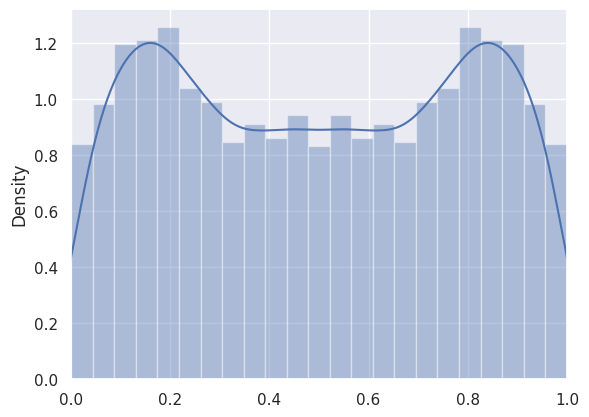

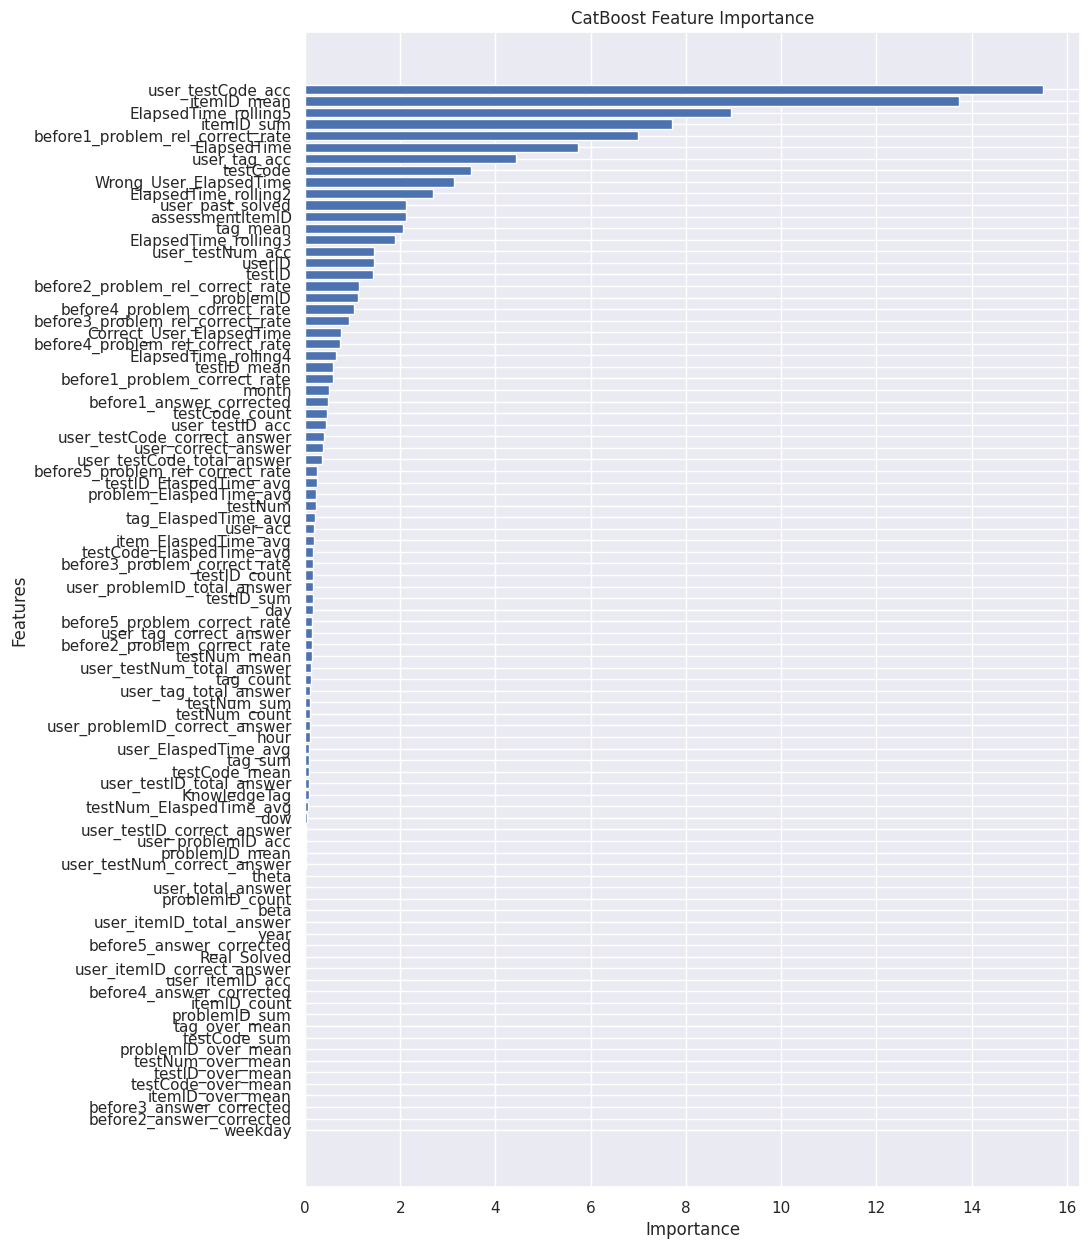

In [238]:
train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)

# Best Parameter 학습
param = study.best_params
# param = {'learning_rate': 0.5, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

cat_clf = CatBoostClassifier(**param, iterations = 5000, 
                             loss_function = 'Logloss', eval_metric = 'AUC',
                             use_best_model = True, random_state = SEED, task_type = 'GPU', devices = '0',
                             cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
cat_clf.fit(train_data, eval_set = [valid_data], verbose = 300, early_stopping_rounds = 100) # train_data

# 모델 지표 출력
proba = cat_clf.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

# Feature Importance 출력
plt.figure(figsize = (10, 15))
importances = cat_clf.get_feature_importance(type = 'PredictionValuesChange') # LossFunctionChange
feature_importances = pd.Series(importances, index = X_train.columns).sort_values()
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance') ; plt.ylabel('Features') ; plt.show()

352 / 744


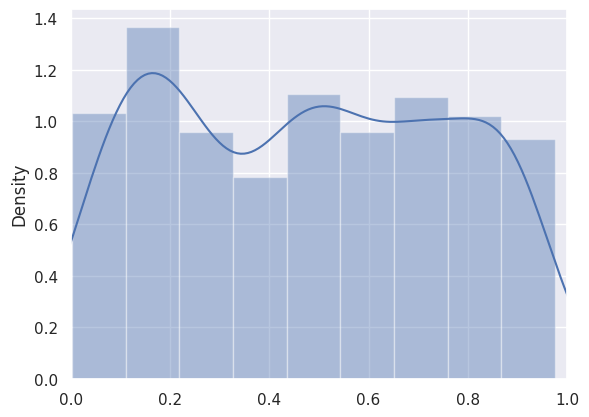

In [239]:
pred = cat_clf.predict(test_df[use_col])
proba = cat_clf.predict_proba(test_df[use_col])[:, 1]
print(f'{sum(pred)} / {len(pred)}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

In [240]:
# SAVE OUTPUT
output_dir = 'submit/'
write_path = os.path.join(output_dir, 'CATCLF_NewHPO_Feature91.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(proba) : # pred
        w.write('{},{}\n'.format(id, p))

Writing Prediction : submit/CATCLF_NewHPO_Feature91.csv


#### CatboostRegressor

In [ ]:
def objective_CAT_REG(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        # 'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    model = CatBoostRegressor(**param, iterations = 5000, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(train_data, eval_set = [train_data, valid_data], verbose = 500,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    pred = cat_model.predict(X_valid)
    score = mean_squred_error(y_valid, pred, squared = False)
    return score

In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_CAT_REG(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 30)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

In [ ]:
train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)

# Best Parameter 학습
# param = study.best_params
param = {'learning_rate': 0.5, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} # 'colsample_bylevel': 0.1,

cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                             loss_function = 'RMSE', eval_metric = 'RMSE', 
                             use_best_model = True, random_state = SEED, task_type = 'GPU', devices = '0',
                             cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
cat_reg.fit(train_data, eval_set = [valid_data], verbose = 300, early_stopping_rounds = 100) # train_data

# 모델 지표 출력
pred = cat_reg.predict(X_valid)
pred = (pred - min(pred)) / (max(pred) - min(pred))
roc_auc = roc_auc_score(y_valid, pred)
accuracy = accuracy_score(y_valid, np.where(pred >= 0.5, 1, 0))
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f}')
sns.displot(pred)
plt.show()

# Feature Importance 출력
plt.figure(figsize = (10, 15))
importances = cat_reg.get_feature_importance(type = 'PredictionValuesChange') # LossFunctionChange
feature_importances = pd.Series(importances, index = X_train.columns).sort_values()
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

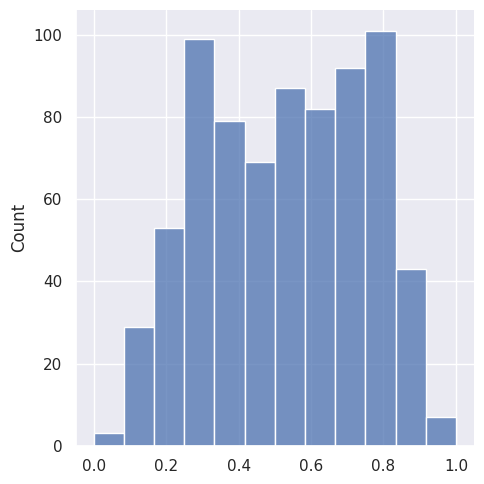

In [ ]:
plt.figure(figsize = (6, 6))
pred = cat_reg.predict(test_df[use_col])
pred = (pred - min(pred)) / (max(pred) - min(pred))
sns.displot(pred)
plt.show()

In [ ]:
# SAVE OUTPUT
output_dir = 'submit/'
write_path = os.path.join(output_dir, 'CAT_REG_HPO_Feature91_05.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(pred) :
        w.write('{},{}\n'.format(id, p))

Writing Prediction : submit/CAT_REG_HPO_Feature91_05.csv


### XGBoost

In [243]:
train_le, test_GB = data[data['answerCode'] != -1], data[data['answerCode'] == -1].drop(columns = 'answerCode')
valid_indices = train.reset_index().groupby('userID', as_index = False).last().set_index('index').index

obj_col = ['assessmentItemID', 'testID']
for col in obj_col :
    le = LabelEncoder()
    train_le[col] = le.fit_transform(train_le[col])
    for label in tqdm.tqdm((test_GB[col].unique())) : 
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_GB[col] = le.transform(test_GB[col])

train_GB = train_le.loc[~train_le.index.isin(valid_indices)]
valid_GB = train_le.loc[train_le.index.isin(valid_indices)]

print(train_GB.shape, valid_GB.shape, test_GB.shape)

100%|██████████| 411/411 [00:00<00:00, 15173.48it/s]


(2518514, 95) (7442, 95) (744, 94)


In [244]:
X_train, y_train = train_GB[use_col], train_GB['answerCode']
X_valid, y_valid = valid_GB[use_col], valid_GB['answerCode']
test_GB = test_GB[use_col]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, test_GB.shape)

(2518514, 91) (2518514,) (7442, 91) (7442,) (744, 91)


#### XGBoostClassifier

##### Optuna HPO

In [258]:
def objective_XGB_CLF(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'booster' : trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.05, 0.1, 0.5]),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.5, 1]),
        'lambda' : trial.suggest_categorical('lambda', [1e-5, 1e-3, 1, 5, 10]),
        'alpha' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_delta_step' : trial.suggest_categorical('max_delta_step', [0.1, 0.5, 1, 5, 10]),
    }

    model = XGBClassifier(**param, n_estimators = 5000, objective = 'binary:logistic', eval_metric = 'auc',
                          nthread = -1, device = 'cuda', tree_method = 'gpu_hist', predictor = 'gpu_predictor', 
                          early_stopping_rounds = 100, random_state = SEED)
    pruning_callback = XGBoostPruningCallback(trial, 'validation_1-' + 'auc')
    xgb_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                          verbose = 300, callbacks = [pruning_callback])
    
    proba = xgb_model.predict_proba(X_valid)
    # score = log_loss(y_valid, proba[:, 1])
    # score = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
    score = roc_auc_score(y_valid, proba[:, 1])
    return score

In [260]:
# Study Optuna
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_XGB_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2024-01-10 10:15:22,811] A new study created in memory with name: no-name-4dc6f0ed-fcaf-4eb0-bc0c-c8e36ad522f1
  0%|          | 0/50 [00:00<?, ?it/s]

[0]	validation_0-auc:0.85125	validation_1-auc:0.81575
[120]	validation_0-auc:0.92054	validation_1-auc:0.82725


Best trial: 0. Best value: 0.834393:   2%|▏         | 1/50 [00:39<32:03, 39.26s/it]

[I 2024-01-10 10:16:02,069] Trial 0 finished with value: 0.8343928641562157 and parameters: {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.5, 'min_child_weight': 7, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 1.0, 'max_delta_step': 10}. Best is trial 0 with value: 0.8343928641562157.
[0]	validation_0-auc:0.78731	validation_1-auc:0.74976
[300]	validation_0-auc:0.83981	validation_1-auc:0.80850
[391]	validation_0-auc:0.83979	validation_1-auc:0.80813


Best trial: 0. Best value: 0.834393:   4%|▍         | 2/50 [01:23<33:38, 42.06s/it]

[I 2024-01-10 10:16:46,090] Trial 1 finished with value: 0.8086116702266237 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.001, 'min_child_weight': 5, 'alpha': 5, 'colsample_bytree': 0.1, 'lambda': 1, 'subsample': 0.8, 'max_delta_step': 5}. Best is trial 0 with value: 0.8343928641562157.
[0]	validation_0-auc:0.69977	validation_1-auc:0.66977
[300]	validation_0-auc:0.86198	validation_1-auc:0.83473
[600]	validation_0-auc:0.86648	validation_1-auc:0.83712
[771]	validation_0-auc:0.86846	validation_1-auc:0.83793


Best trial: 2. Best value: 0.838116:   6%|▌         | 3/50 [01:45<25:47, 32.92s/it]

[I 2024-01-10 10:17:08,138] Trial 2 finished with value: 0.8381156953162443 and parameters: {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.1}. Best is trial 2 with value: 0.8381156953162443.
[0]	validation_0-auc:0.76905	validation_1-auc:0.73420
[300]	validation_0-auc:0.81924	validation_1-auc:0.78607
[377]	validation_0-auc:0.81869	validation_1-auc:0.78534


Best trial: 2. Best value: 0.838116:   8%|▊         | 4/50 [05:11<1:17:39, 101.30s/it]

[I 2024-01-10 10:20:34,251] Trial 3 finished with value: 0.78631700089644 and parameters: {'booster': 'dart', 'max_depth': 8, 'learning_rate': 0.001, 'min_child_weight': 7, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 1, 'subsample': 1.0, 'max_delta_step': 1}. Best is trial 2 with value: 0.8381156953162443.
[0]	validation_0-auc:0.85459	validation_1-auc:0.81541
[109]	validation_0-auc:0.86792	validation_1-auc:0.82926


Best trial: 2. Best value: 0.838116:   8%|▊         | 4/50 [06:04<1:17:39, 101.30s/it]

[I 2024-01-10 10:21:27,300] Trial 4 finished with value: 0.8302221021476035 and parameters: {'booster': 'dart', 'max_depth': 13, 'learning_rate': 0.001, 'min_child_weight': 2, 'alpha': 0.001, 'colsample_bytree': 0.5, 'lambda': 0.001, 'subsample': 0.6, 'max_delta_step': 10}. Best is trial 2 with value: 0.8381156953162443.


Best trial: 2. Best value: 0.838116:  10%|█         | 5/50 [06:04<1:02:55, 83.90s/it] 

[0]	validation_0-auc:0.77954	validation_1-auc:0.72818


Best trial: 2. Best value: 0.838116:  12%|█▏        | 6/50 [06:12<42:30, 57.96s/it]  

[I 2024-01-10 10:21:34,903] Trial 5 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  14%|█▍        | 7/50 [06:19<29:39, 41.37s/it]

[I 2024-01-10 10:21:42,136] Trial 6 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85684	validation_1-auc:0.81398
[155]	validation_0-auc:0.86842	validation_1-auc:0.82954


Best trial: 2. Best value: 0.838116:  16%|█▌        | 8/50 [06:48<26:19, 37.61s/it]

[I 2024-01-10 10:22:11,690] Trial 7 finished with value: 0.8301211686373094 and parameters: {'booster': 'gbtree', 'max_depth': 13, 'learning_rate': 0.001, 'min_child_weight': 3, 'alpha': 1e-05, 'colsample_bytree': 0.5, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 10}. Best is trial 2 with value: 0.8381156953162443.


Best trial: 2. Best value: 0.838116:  18%|█▊        | 9/50 [06:56<19:13, 28.15s/it]

[I 2024-01-10 10:22:19,022] Trial 8 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.74678	validation_1-auc:0.70712


Best trial: 2. Best value: 0.838116:  20%|██        | 10/50 [07:03<14:28, 21.72s/it]

[I 2024-01-10 10:22:26,341] Trial 9 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  22%|██▏       | 11/50 [07:10<11:15, 17.33s/it]

[I 2024-01-10 10:22:33,726] Trial 10 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  24%|██▍       | 12/50 [07:18<09:03, 14.30s/it]

[I 2024-01-10 10:22:41,113] Trial 11 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.84751	validation_1-auc:0.81315
[121]	validation_0-auc:0.90016	validation_1-auc:0.82147


Best trial: 2. Best value: 0.838116:  26%|██▌       | 13/50 [07:30<08:23, 13.62s/it]

[I 2024-01-10 10:22:53,142] Trial 12 finished with value: 0.8331992973900177 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 0.7, 'max_delta_step': 10}. Best is trial 2 with value: 0.8381156953162443.


Best trial: 2. Best value: 0.838116:  28%|██▊       | 14/50 [07:37<07:02, 11.73s/it]

[I 2024-01-10 10:23:00,515] Trial 13 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  30%|███       | 15/50 [07:45<06:04, 10.41s/it]

[I 2024-01-10 10:23:07,866] Trial 14 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  32%|███▏      | 16/50 [07:52<05:23,  9.52s/it]

[I 2024-01-10 10:23:15,307] Trial 15 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  34%|███▍      | 17/50 [08:00<04:54,  8.91s/it]

[I 2024-01-10 10:23:22,815] Trial 16 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.79009	validation_1-auc:0.74751


Best trial: 2. Best value: 0.838116:  36%|███▌      | 18/50 [08:07<04:31,  8.47s/it]

[I 2024-01-10 10:23:30,267] Trial 17 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.70253	validation_1-auc:0.67188


Best trial: 2. Best value: 0.838116:  38%|███▊      | 19/50 [08:14<04:13,  8.16s/it]

[I 2024-01-10 10:23:37,708] Trial 18 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  40%|████      | 20/50 [08:22<03:57,  7.92s/it]

[I 2024-01-10 10:23:45,059] Trial 19 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85522	validation_1-auc:0.81856


Best trial: 2. Best value: 0.838116:  42%|████▏     | 21/50 [08:29<03:47,  7.85s/it]

[I 2024-01-10 10:23:52,732] Trial 20 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.84751	validation_1-auc:0.81315
[121]	validation_0-auc:0.90016	validation_1-auc:0.82147


Best trial: 2. Best value: 0.838116:  44%|████▍     | 22/50 [08:41<04:13,  9.06s/it]

[I 2024-01-10 10:24:04,617] Trial 21 finished with value: 0.8331992973900177 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 0.7, 'max_delta_step': 10}. Best is trial 2 with value: 0.8381156953162443.
[0]	validation_0-auc:0.85028	validation_1-auc:0.81468


Best trial: 2. Best value: 0.838116:  46%|████▌     | 23/50 [08:49<03:51,  8.58s/it]

[I 2024-01-10 10:24:12,099] Trial 22 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.84421	validation_1-auc:0.80783


Best trial: 2. Best value: 0.838116:  48%|████▊     | 24/50 [08:56<03:33,  8.22s/it]

[I 2024-01-10 10:24:19,471] Trial 23 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85030	validation_1-auc:0.81640
[213]	validation_0-auc:0.86891	validation_1-auc:0.83577


Best trial: 2. Best value: 0.838116:  50%|█████     | 25/50 [09:08<03:52,  9.31s/it]

[I 2024-01-10 10:24:31,329] Trial 24 finished with value: 0.8361084447269955 and parameters: {'booster': 'gbtree', 'max_depth': 13, 'learning_rate': 0.5, 'min_child_weight': 6, 'alpha': 10, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 0.7, 'max_delta_step': 10}. Best is trial 2 with value: 0.8381156953162443.


Best trial: 2. Best value: 0.838116:  52%|█████▏    | 26/50 [09:15<03:29,  8.71s/it]

[I 2024-01-10 10:24:38,647] Trial 25 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85137	validation_1-auc:0.81664


Best trial: 2. Best value: 0.838116:  54%|█████▍    | 27/50 [09:23<03:13,  8.39s/it]

[I 2024-01-10 10:24:46,287] Trial 26 pruned. Trial was pruned at iteration 2.
[0]	validation_0-auc:0.84900	validation_1-auc:0.81597


Best trial: 2. Best value: 0.838116:  56%|█████▌    | 28/50 [09:31<02:59,  8.15s/it]

[I 2024-01-10 10:24:53,865] Trial 27 pruned. Trial was pruned at iteration 1.


Best trial: 2. Best value: 0.838116:  58%|█████▊    | 29/50 [09:38<02:45,  7.86s/it]

[I 2024-01-10 10:25:01,057] Trial 28 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.78650	validation_1-auc:0.74935


Best trial: 2. Best value: 0.838116:  60%|██████    | 30/50 [09:45<02:34,  7.71s/it]

[I 2024-01-10 10:25:08,426] Trial 29 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.73843	validation_1-auc:0.71466


Best trial: 2. Best value: 0.838116:  62%|██████▏   | 31/50 [09:53<02:24,  7.62s/it]

[I 2024-01-10 10:25:15,835] Trial 30 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85028	validation_1-auc:0.81468


Best trial: 2. Best value: 0.838116:  64%|██████▍   | 32/50 [10:00<02:17,  7.64s/it]

[I 2024-01-10 10:25:23,378] Trial 31 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.84421	validation_1-auc:0.80797


Best trial: 2. Best value: 0.838116:  66%|██████▌   | 33/50 [10:08<02:08,  7.57s/it]

[I 2024-01-10 10:25:30,913] Trial 32 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85243	validation_1-auc:0.81579


Best trial: 2. Best value: 0.838116:  68%|██████▊   | 34/50 [10:15<02:00,  7.53s/it]

[I 2024-01-10 10:25:38,351] Trial 33 pruned. Trial was pruned at iteration 1.


Best trial: 2. Best value: 0.838116:  70%|███████   | 35/50 [10:22<01:52,  7.49s/it]

[I 2024-01-10 10:25:45,751] Trial 34 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  72%|███████▏  | 36/50 [10:30<01:45,  7.51s/it]

[I 2024-01-10 10:25:53,292] Trial 35 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.77479	validation_1-auc:0.73978


Best trial: 2. Best value: 0.838116:  74%|███████▍  | 37/50 [10:37<01:37,  7.49s/it]

[I 2024-01-10 10:26:00,747] Trial 36 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.83427	validation_1-auc:0.78047


Best trial: 2. Best value: 0.838116:  76%|███████▌  | 38/50 [10:45<01:29,  7.48s/it]

[I 2024-01-10 10:26:08,220] Trial 37 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85158	validation_1-auc:0.81690


Best trial: 2. Best value: 0.838116:  78%|███████▊  | 39/50 [10:53<01:23,  7.59s/it]

[I 2024-01-10 10:26:16,061] Trial 38 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.85037	validation_1-auc:0.81473


Best trial: 2. Best value: 0.838116:  80%|████████  | 40/50 [11:00<01:15,  7.57s/it]

[I 2024-01-10 10:26:23,593] Trial 39 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.69943	validation_1-auc:0.66862


Best trial: 2. Best value: 0.838116:  82%|████████▏ | 41/50 [11:08<01:08,  7.58s/it]

[I 2024-01-10 10:26:31,032] Trial 40 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.84751	validation_1-auc:0.81315
[120]	validation_0-auc:0.90002	validation_1-auc:0.82156


Best trial: 2. Best value: 0.838116:  84%|████████▍ | 42/50 [11:20<01:10,  8.83s/it]

[I 2024-01-10 10:26:42,949] Trial 41 finished with value: 0.8331992973900177 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 0.7, 'max_delta_step': 10}. Best is trial 2 with value: 0.8381156953162443.
[0]	validation_0-auc:0.84750	validation_1-auc:0.81323
[117]	validation_0-auc:0.89800	validation_1-auc:0.82587


Best trial: 2. Best value: 0.838116:  86%|████████▌ | 43/50 [11:31<01:07,  9.66s/it]

[I 2024-01-10 10:26:54,546] Trial 42 finished with value: 0.8358919418053445 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.5, 'min_child_weight': 9, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 0.7, 'max_delta_step': 10}. Best is trial 2 with value: 0.8381156953162443.
[0]	validation_0-auc:0.84034	validation_1-auc:0.80158


Best trial: 2. Best value: 0.838116:  88%|████████▊ | 44/50 [11:39<00:53,  8.95s/it]

[I 2024-01-10 10:27:01,846] Trial 43 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.84420	validation_1-auc:0.80802


Best trial: 2. Best value: 0.838116:  90%|█████████ | 45/50 [11:46<00:42,  8.46s/it]

[I 2024-01-10 10:27:09,165] Trial 44 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  92%|█████████▏| 46/50 [11:53<00:32,  8.13s/it]

[I 2024-01-10 10:27:16,518] Trial 45 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.78046	validation_1-auc:0.74302


Best trial: 2. Best value: 0.838116:  94%|█████████▍| 47/50 [12:01<00:23,  7.97s/it]

[I 2024-01-10 10:27:24,104] Trial 46 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  96%|█████████▌| 48/50 [12:08<00:15,  7.80s/it]

[I 2024-01-10 10:27:31,512] Trial 47 pruned. Trial was pruned at iteration 0.


Best trial: 2. Best value: 0.838116:  98%|█████████▊| 49/50 [12:16<00:07,  7.67s/it]

[I 2024-01-10 10:27:38,884] Trial 48 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.67475	validation_1-auc:0.65486


Best trial: 2. Best value: 0.838116: 100%|██████████| 50/50 [12:23<00:00, 14.87s/it]

[I 2024-01-10 10:27:46,364] Trial 49 pruned. Trial was pruned at iteration 0.
Best trial : score 0.8381156953162443, 
 params = {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.1} 



- Best trial : score 0.8381156953162443 
    - params = {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.1}

##### Train

[0]	validation_0-auc:0.70224	validation_1-auc:0.67141
[300]	validation_0-auc:0.86200	validation_1-auc:0.83242
[600]	validation_0-auc:0.86645	validation_1-auc:0.83517
[770]	validation_0-auc:0.86850	validation_1-auc:0.83529
ROC-AUC Score : 0.8355 / Accuracy : 0.7548 / Logloss : 0.4994


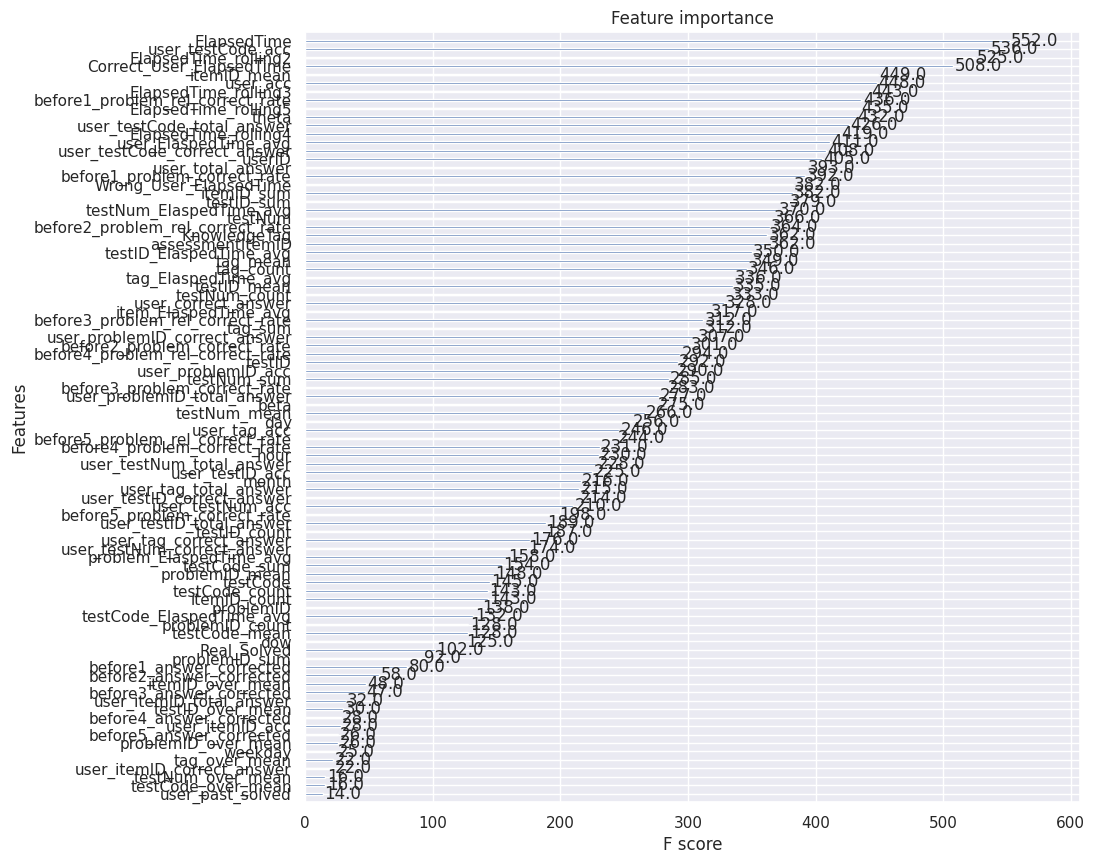

In [261]:
param = study.best_params
# param = {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.01, 'min_child_weight': 8, 'alpha': 0.001, 'colsample_bytree': 0.5, 'lambda': 10, 'subsample': 0.7, 'max_delta_step': 0.5}

xgb_clf = XGBClassifier(**param, n_estimators = 5000, objective = 'binary:logistic', eval_metric = 'auc',
                        nthread = -1, device = 'cuda', tree_method = 'gpu_hist', predictor = 'gpu_predictor', 
                        early_stopping_rounds = 100, random_state = SEED)
xgb_clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 300)

# 모델 지표 출력
proba = xgb_clf.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')

# Feature Importance 출력
fig, ax = plt.subplots(figsize = (10, 10))
xgb_plot_importance(xgb_clf, ax = ax, importance_type = 'weight')
plt.show()

In [106]:
# xgb_clf.save_model('./model/XGB_Feature91.model')

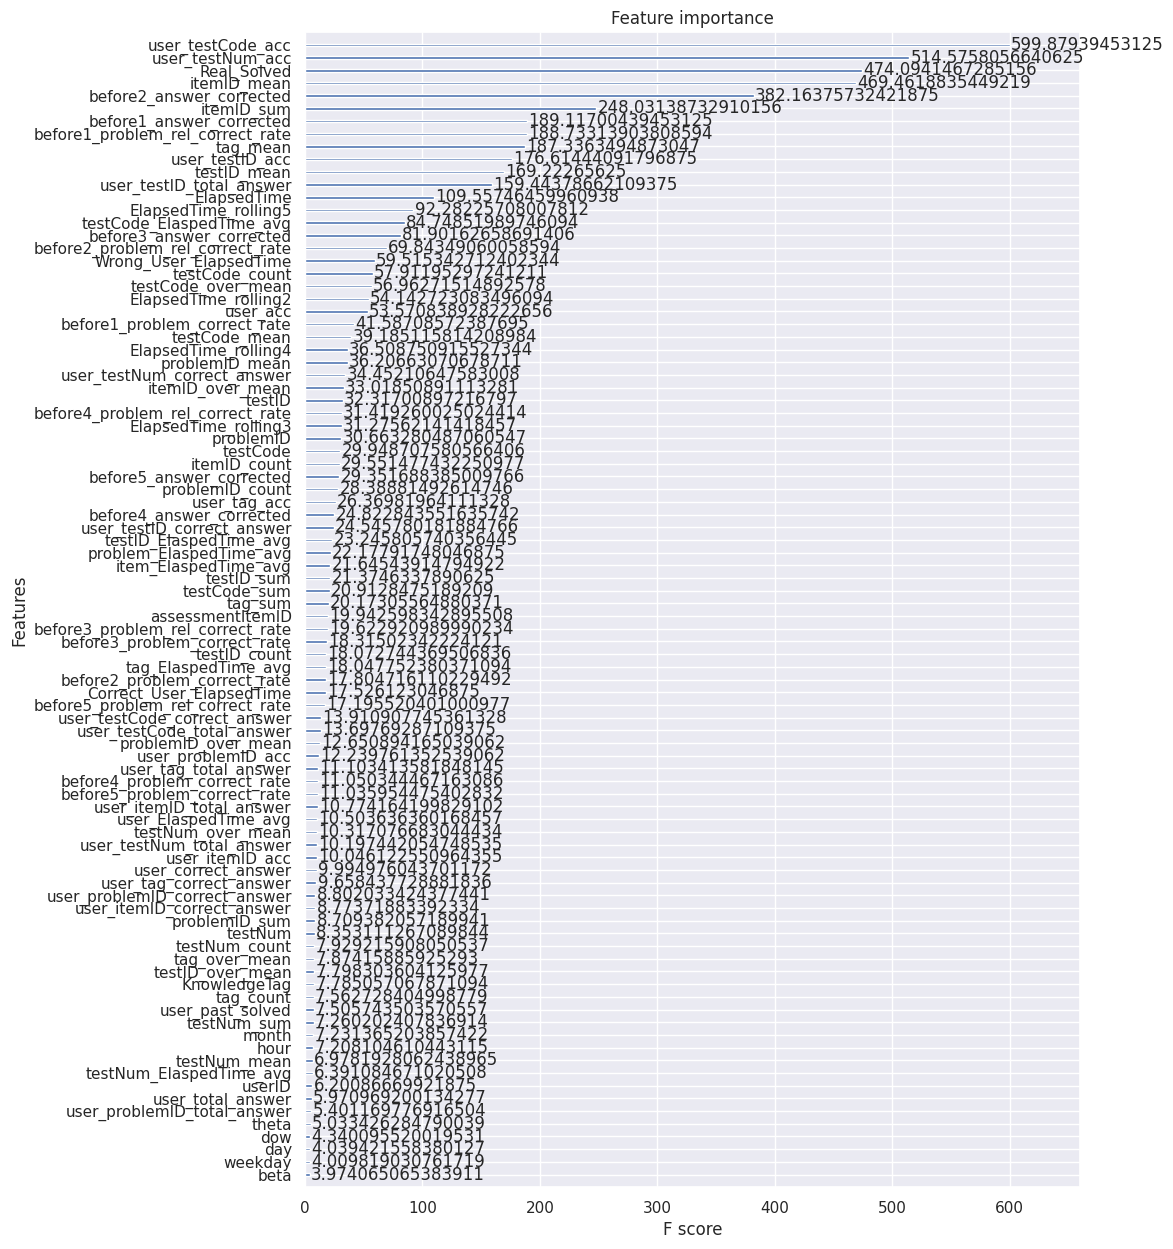

In [262]:
# Feature Importance 출력
fig, ax = plt.subplots(figsize = (10, 15))
xgb_plot_importance(xgb_clf, ax = ax, importance_type = 'gain')
plt.show()

367 / 744
0.0028186361 0.9818303


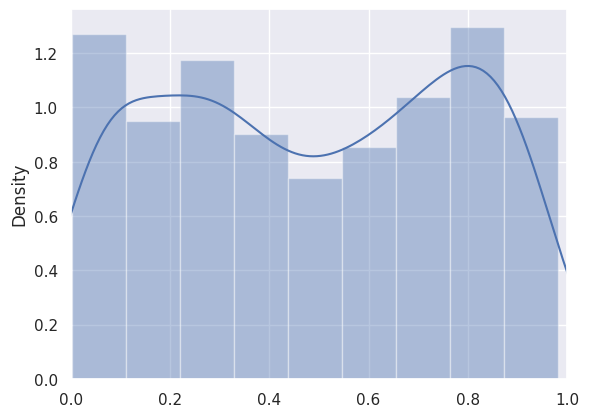

In [263]:
# xgb_clf.load_model('./model/XGB_Feature91.model')
pred = xgb_clf.predict(test_GB[use_col])
proba = xgb_clf.predict_proba(test_GB[use_col])[:, 1]
print(f'{sum(pred)} / {len(pred)}') ; print(min(proba), max(proba))
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

In [264]:
# SAVE OUTPUT
output_dir = 'submit/'
write_path = os.path.join(output_dir, 'XGBCLF_NewHPO_Feature91.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(proba) :
        w.write('{},{}\n'.format(id, p))

Writing Prediction : submit/XGBCLF_NewHPO_Feature91.csv


#### SHAP

In [265]:
import shap

# SHAP을 사용한 모델 예측 설명
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X_train)
shap_values

.values =
array([[-0.01593348,  0.03354772,  0.05377585, ...,  0.29445514,
         0.01925885,  0.01813828],
       [ 0.07386987, -0.00670526,  0.02219864, ...,  0.17692907,
         0.06368961,  0.068691  ],
       [ 0.10398266,  0.00070534,  0.04514203, ...,  0.08756183,
         0.06505087, -0.04223182],
       ...,
       [-0.12890062,  0.00988005,  0.05399852, ...,  0.07364039,
         0.01435249, -0.01517283],
       [-0.1716563 ,  0.0205669 ,  0.02528446, ..., -0.18291762,
        -0.00567247,  0.01024584],
       [-0.21114363, -0.00689327, -0.01096537, ...,  0.01022033,
        -0.01273211,  0.01334722]], dtype=float32)

.base_values =
array([0.64823043, 0.64823043, 0.64823043, ..., 0.64823043, 0.64823043,
       0.64823043], dtype=float32)

.data =
array([[ 0.00000000e+00,  5.35400000e+03,  7.22400000e+03, ...,
         1.38130081e+01,  5.78201756e-01, -3.34217592e+00],
       [ 0.00000000e+00,  5.35500000e+03,  7.22500000e+03, ...,
         2.45826446e+01,  5.78201756e-01, 

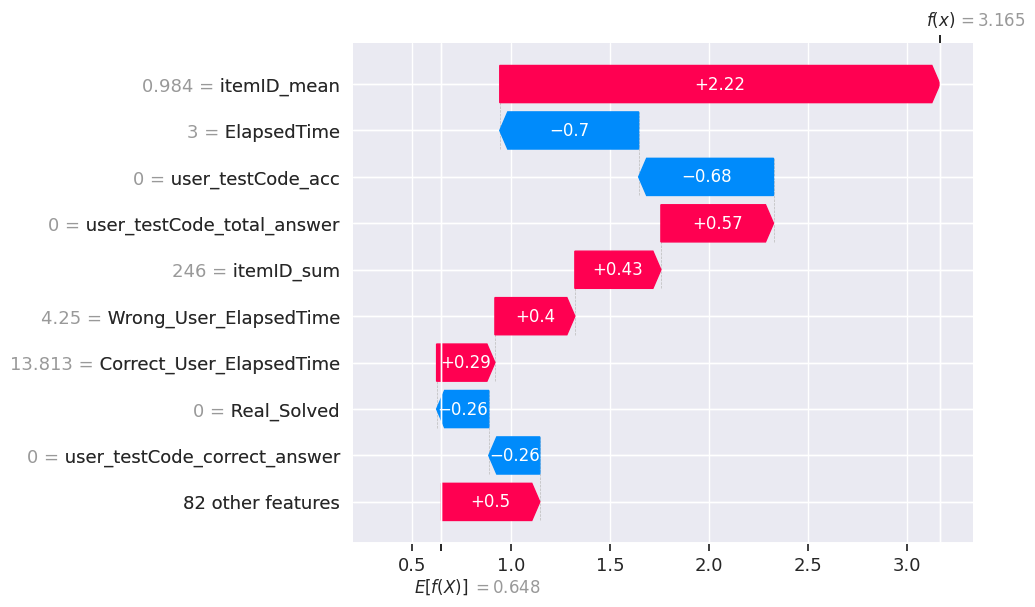

In [266]:
# 첫 번째 예측 설명의 시각화
shap.plots.waterfall(shap_values[0])

In [269]:
# Force Plot을 활용한 첫 번째 예측 설명의 시각화
shap.plots.force(shap_values[0])

In [270]:
# 모든 훈련 데이터 세트에 대한 시각화
shap.plots.force(shap_values)

: 

In [ ]:
# 모든 변수의 영향도 요약
shap.plots.beeswarm(shap_values)

In [ ]:
# 모든 변수의 영향도 요약
shap.plots.bar(shap_values)

In [ ]:
explainer.shap_interaction_values(X_train)

### LightGBM

In [9]:
train_le, test_GB = data[data['answerCode'] != -1], data[data['answerCode'] == -1].drop(columns = 'answerCode')
valid_indices = train.reset_index().groupby('userID', as_index = False).last().set_index('index').index

obj_col = ['assessmentItemID', 'testID']
for col in obj_col :
    le = LabelEncoder()
    train_le[col] = le.fit_transform(train_le[col])
    for label in tqdm.tqdm((test_GB[col].unique())) : 
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_GB[col] = le.transform(test_GB[col])

train_GB = train_le.loc[~train_le.index.isin(valid_indices)]
valid_GB = train_le.loc[train_le.index.isin(valid_indices)]

print(train_GB.shape, valid_GB.shape, test_GB.shape)

100%|██████████| 411/411 [00:00<00:00, 15893.23it/s]


(2519260, 95) (6696, 95) (744, 94)


In [10]:
X_train, y_train = train_GB[use_col], train_GB['answerCode']
X_valid, y_valid = valid_GB[use_col], valid_GB['answerCode']
test_GB = test_GB[use_col]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, test_GB.shape)

(2519260, 91) (2519260,) (6696, 91) (6696,) (744, 91)


In [11]:
def objective_LGBM_CLF(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'boosting_type' : trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves' : trial.suggest_int('num_leaves', 30, 50),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'subsample' : trial.suggest_categorical('subsample', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'reg_alpha' : trial.suggest_categorical('reg_alpha', [1e-3, 0.1, 1, 5, 10]),
        'reg_lambda' : trial.suggest_categorical('reg_lambda', [1e-3, 0.1, 1, 5, 10]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1e-3, 0.1, 1, 5, 10]),
    }
    lgbm_model = LGBMClassifier(**param, n_estimators = 5000, objective = 'binary', metric = 'auc',
                                n_jobs = -1, verbose = -1, random_state = SEED)
    callback = lightgbm.early_stopping(stopping_rounds = 100)
    pruning_callback = LightGBMPruningCallback(trial, 'auc', valid_name = 'valid_1')
    lgbm_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                   eval_metric = 'auc', callbacks = [callback, pruning_callback])

    proba = lgbm_model.predict_proba(X_valid)
    # score = log_loss(y_valid, proba[:, 1])
    # score = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
    score = roc_auc_score(y_valid, proba[:, 1])
    return score

In [12]:
# Study Optuna
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_LGBM_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2024-01-10 11:16:04,303] A new study created in memory with name: no-name-74172f27-0b20-4d77-ac0e-475d73e0471d
Best trial: 0. Best value: 0.860516:   2%|▏         | 1/50 [1:18:55<64:27:14, 4735.39s/it]

[I 2024-01-10 12:34:59,685] Trial 0 finished with value: 0.8605161165488774 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'subsample': 1.0, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 0 with value: 0.8605161165488774.


Best trial: 0. Best value: 0.860516:   2%|▏         | 1/50 [2:36:53<128:08:03, 9413.95s/it]


[W 2024-01-10 13:52:58,253] Trial 1 failed with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'subsample': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'min_child_weight': 0.1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/data/ephemeral/.cache/pypoetry/virtualenvs/level2-dkt-recsys-05-ywsvzukT-py3.10/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_688012/1214634904.py", line 3, in <lambda>
    study.optimize(lambda trial : objective_LGBM_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 50)
  File "/tmp/ipykernel_688012/2391395579.py", line 17, in objective_LGBM_CLF
    lgbm_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
  File "/data/ephemeral/.cache/pypoetry/virtualenvs/level2-dkt-recsys-05-ywsvzukT-py3.10/

KeyboardInterrupt: 

ROC-AUC Score : 0.7332 / Accuracy : 0.7329 / Logloss : 0.5268


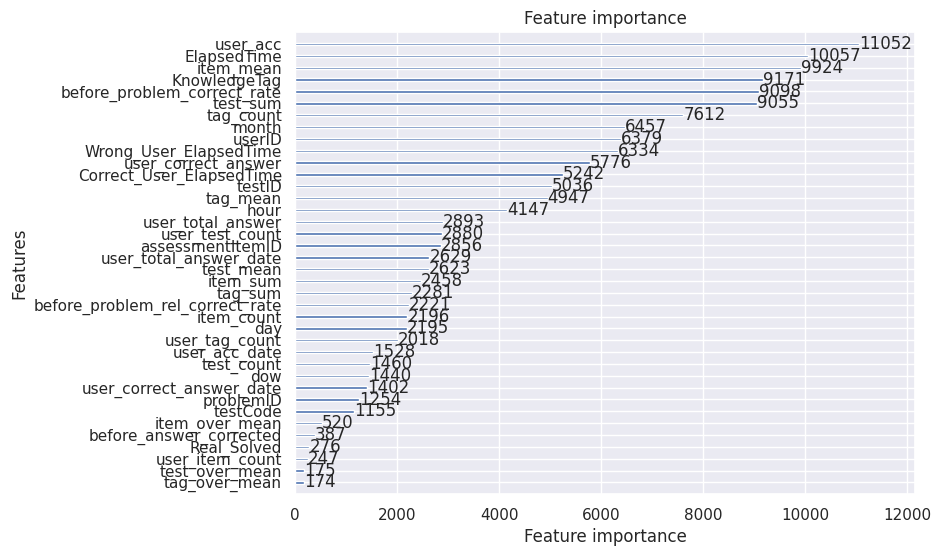

In [ ]:
param = study.best_params

lgbm_clf = LGBMClassifier(**param, n_estimators = 5000, objective = 'binary', metric = 'auc',
                          n_jobs = -1, verbose = -1, random_state = SEED)
callback = lightgbm.early_stopping(stopping_rounds = 100)
lgbm_clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
             eval_metric = 'auc', callbacks = [callback])

# 모델 지표 출력
proba = lgbm_clf.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')

# Feature Importance 출력
fig, ax = plt.subplots(figsize = (10, 15))
lgbm_plot_importance(lgbm_clf, ax = ax)
plt.show()

In [ ]:
pred = lgbm_clf.predict(test_GB[use_col])
print(f'{sum(pred)} / {len(pred)}')

367 / 744


In [ ]:
# SAVE OUTPUT
output_dir = 'submit/'
write_path = os.path.join(output_dir, 'LGBM_HPO.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(pred) :
        w.write('{},{}\n'.format(id, p))

Writing Prediction : submit/LGBM_HPO.csv


### ETC

- K-Fold 기법 좀 고민해봐야할듯
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit

```
tscv = TimeSeriesSplit(n_splits=3, test_size=2)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
```

In [ ]:
X_data, y_data = train_df.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    # Best Parameter 학습
    param = study.best_params
    
    cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                                loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [i for i in range(0, 13)])
    cat_reg.fit(train_data, eval_set = [train_data, valid_data], use_best_model = True,
                verbose = 500, early_stopping_rounds = 100)
    
    # Feature Importance 출력
    feature_importance = cat_reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize = (12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
    plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = cat_reg.predict(test_df.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
print(f'CatBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

In [ ]:
X_data, y_data = train_GB[use_col], train_GB['answerCode']

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
valid_auc = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx] 
    
    # Best Parameter 학습
    param = study.best_params
    
    xgb_clf = XGBClassifier(**param, n_estimators = 5000, objective = 'binary:logistic', eval_metric = 'auc',
                          nthread = -1, device = 'cuda', tree_method = 'gpu_hist', predictor = 'gpu_predictor', 
                          early_stopping_rounds = 100, random_state = SEED)
    xgb_clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 300)
    
    # Feature Importance 출력
    fig, ax = plt.subplots(figsize = (10, 10))
    xgb_plot_importance(xgb_clf, ax = ax, importance_type = 'gain')
    plt.show()
    
    # 모델 지표 출력
    pred = xgb_clf.predict(X_valid)
    proba = xgb_clf.predict_proba(X_valid)
    roc_auc = roc_auc_score(y_valid, proba[:, 1])
    accuracy = accuracy_score(y_valid, np.where(pred >= 0.5, 1, 0))
    logloss = log_loss(y_valid, proba[:, 1])
    valid_auc.append(roc_auc)
    print(f'Valid Set {fold + 1} 번째 Fold AUROC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')
    
    # Predict
    pred = xgb_clf.predict(test_df.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
    pred = xgb_clf.predict(test_GB[use_col])
    print(f'Valid Set {fold + 1} 번째 Fold Prediction : {sum(pred)} / {len(pred)}')
    pred_df[f'pred_{fold}'] = pred
print(f'XGBoost AUROC 평균 : {np.array(valid_auc).mean():.5f} \n')